In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sb

# from kmodes.kprototypes import KPrototypes
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
## Read the supercritical coal power plant data

super_critical = pd.read_csv('CEEW_supercritical_with_ws_price.csv')

all_heat_rate = super_critical['Actual SHR']* 3.96567/1000
all_capacity  = super_critical['Capacity']
all_age       = super_critical['Age']
all_region     = super_critical['Region']
all_PLF        = super_critical['Actual avg PLF']
all_water_stress = super_critical['bws_score']
all_price = super_critical['coal_price']


1. Find the correlation between the features

In [3]:
data = pd.DataFrame({'heat_rate': all_heat_rate,
                     'capacity': all_capacity,
                     'age': all_age, 
                     'PLF': all_PLF,
                     'water stress': all_water_stress,
                     'region': all_region,
                     'price': all_price
                     })

# change the state to one hot encoding
data = pd.get_dummies(data, columns=['region']) # aggregate the states here. 

print(data.head())

   heat_rate  capacity       age       PLF  water stress  price  region_ER  \
0  10.619654     800.0  0.342231  0.005858      0.083791   1.66          1   
1  10.423931     800.0  1.067762  0.171927      0.480176   1.72          0   
2   9.845797     800.0  1.960301  0.633565      0.250206   2.04          0   
3  10.429779     800.0  2.091718  0.191133      0.139977   1.59          0   
4  10.657335     800.0  3.091034  0.040648      0.331244   3.46          0   

   region_NR  region_SR  region_WR  
0          0          0          0  
1          0          0          1  
2          0          1          0  
3          0          0          1  
4          0          1          0  


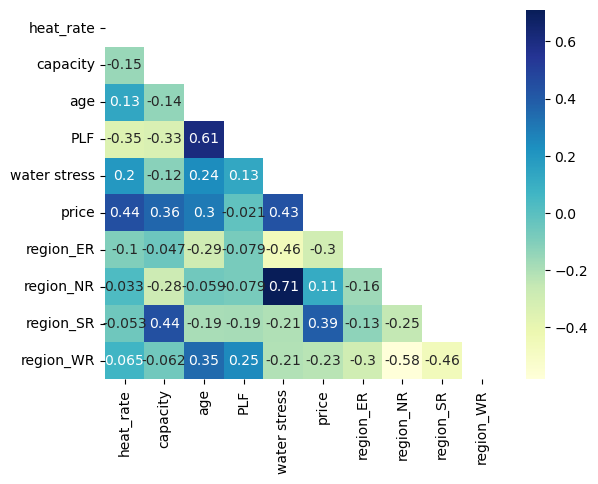

In [4]:
mask = np.triu(np.ones_like(data.corr()))
dataplot = sb.heatmap(data.corr(), cmap="YlGnBu", annot=True, mask=mask)
plt.savefig('ML_training_plots/Feature_correlation_super.png', bbox_inches='tight')

2. Fit the prediction model using data

In [6]:
X = data.drop('heat_rate', axis=1)
y = data['heat_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = preprocessing.StandardScaler()
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# add constant
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]

In [7]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge

In [8]:
good_models = {
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=15, loss='absolute_error'),
    'RandomForestRegressor': RandomForestRegressor(max_depth=None), # depth
    'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=None), # depth
    'XGBRegressor': XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=150), 
    'LinearRegression': LinearRegression(), # no hyperparameters
    'RidgeRegression': Ridge(alpha=1.0), # alpha
    'SVR': SVR(),
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=2, weights='distance'),
}


In [9]:
# Cross validation
kf = KFold(n_splits=5)
res = {}

# use mean squared error, mean absolute error, mean absolute percentage error
for name, model in good_models.items():
    print(name)
    scores = cross_validate(model, X_train, y_train, cv=kf, scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'))
    res[name] = scores

GradientBoostingRegressor
RandomForestRegressor
DecisionTreeRegressor
XGBRegressor
LinearRegression
RidgeRegression
SVR
KNeighborsRegressor


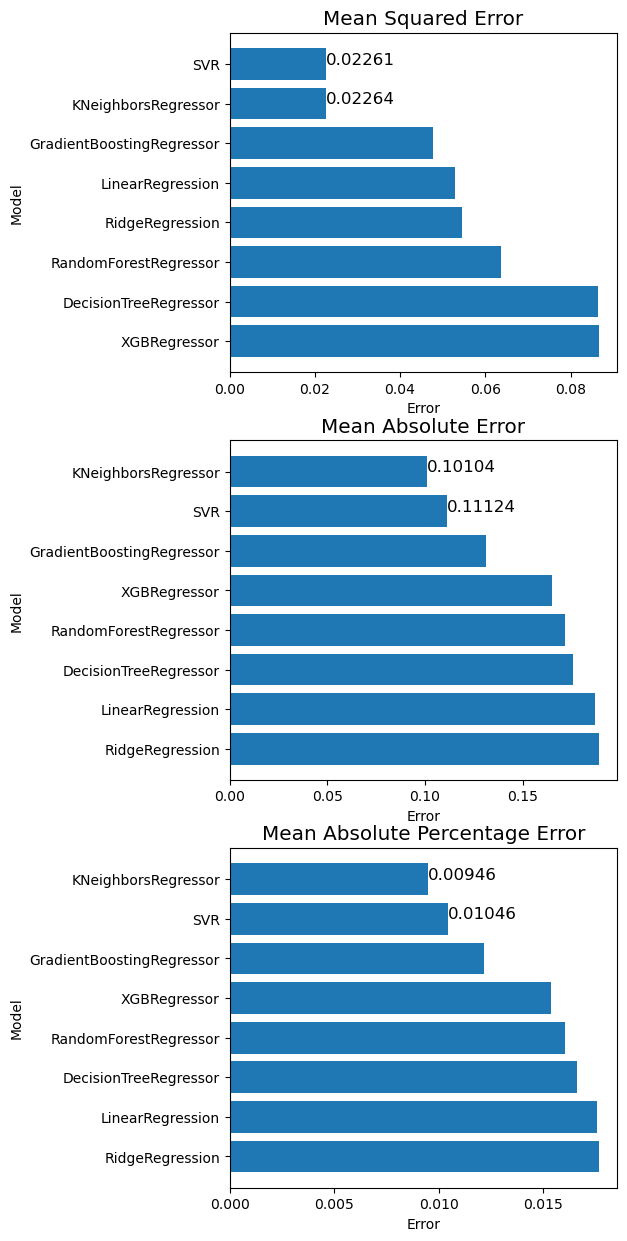

In [10]:
# taking the negative mean. test_neg_mean_squared_error, test_neg_mean_absolute_error, test_neg_mean_absolute_percentage_error
res_mean = {name: {'test_mean_squared_error': -np.mean(scores['test_neg_mean_squared_error']), 'test_mean_absolute_error': -np.mean(scores['test_neg_mean_absolute_error']), 'test_mean_absolute_percentage_error': -np.mean(scores['test_neg_mean_absolute_percentage_error'])} for name, scores in res.items()}
titles = {
    'test_mean_squared_error': 'Mean Squared Error',
    'test_mean_absolute_error': 'Mean Absolute Error',
    'test_mean_absolute_percentage_error': 'Mean Absolute Percentage Error'

}
# 3 horizontal bar plots for each of the errors.
fig, ax = plt.subplots(3, 1, figsize=(5, 15))
plt.rcParams.update({'font.size': 12})
for i, error in enumerate(['test_mean_squared_error', 'test_mean_absolute_error', 'test_mean_absolute_percentage_error']):
    # sort by the error
    res_mean = dict(sorted(res_mean.items(), key=lambda item: -item[1][error]))

    ax[i].barh(list(res_mean.keys()), [res_mean[name][error] for name in res_mean])
    ax[i].set_title(titles[error])
    ax[i].set_xlabel('Error')
    ax[i].set_ylabel('Model')

    # label bars with values
    for index, value in enumerate([res_mean[name][error] for name in res_mean]):
        if index > 5:
            ax[i].text(value, index, str(round(value, 5)))
# save
plt.savefig('ML_training_plots/Model_comparison_super.png', bbox_inches='tight')

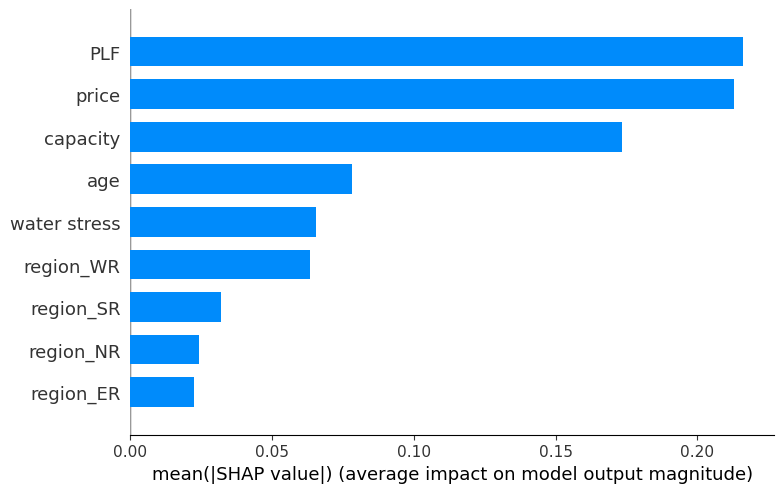

In [11]:
import shap
idx = 1
sorted_model_names = sorted(good_models.keys(), key=lambda name: res_mean[name]['test_mean_squared_error'])
for name in sorted_model_names:
    model = good_models[name]
    if (name in ['KNeighborsRegressor', 'SVR', 'LinearRegression', 'RidgeRegression']):
        model.fit(X_train, y_train)
        explainer = shap.Explainer(model.predict, X_train)
        shap_values = explainer(X_train)
    else:
        model.fit(X_train, y_train)
        explainer = shap.Explainer(model)
        shap_values = explainer(X_train)
    features_names = [0] + list(X.columns)
    shap.summary_plot(shap_values, X_train,
                      feature_names=[0] + list(X.columns), plot_type='bar',
                      max_display=9, show=False)
    plt.savefig('./SHAP_plot/'+str(name)+'_summary_supercritical.png')
    idx += 1

3. Predict the heat rate of GEM database

In [11]:
## Read the supercritical coal power plant data

gem_coal = pd.read_csv('gem_with_ws_price.csv')
gem_super_critical = gem_coal[gem_coal['Combustion technology']=='supercritical']
gem_super_critical = gem_super_critical[gem_super_critical['Status']=='operating']

gem_heat_rate = gem_super_critical['Heat rate (Btu per kWh)'] /1000
gem_capacity  = gem_super_critical['Capacity (MW)']
gem_age       = 50-gem_super_critical['Remaining plant lifetime (years)']
gem_state     = gem_super_critical['Subnational unit (province, state)']
gem_price = gem_super_critical['coal_price']
gem_water_stress = gem_super_critical['bws_score']

gem_state = gem_state.reindex()

# replace Punjab state with punjab
gem_state = gem_state.replace('Punjab state', 'Punjab')

state_to_zone = pd.read_csv('30_to_5zones.csv')
gem_state_with_zone = pd.merge(gem_super_critical, state_to_zone, left_on='Subnational unit (province, state)', right_on='States', how='left')
gem_zone = gem_state_with_zone["Region_y"]
gem_zone

0      SR
1      SR
2      NR
3      NR
4      NR
       ..
97     SR
98     SR
99     WR
100    SR
101    SR
Name: Region_y, Length: 102, dtype: object

In [12]:
X_prediction = pd.DataFrame(
    {
        "heat_rate": gem_heat_rate.values,
        "capacity": gem_capacity.values,
        "age": gem_age.values,
        "PLF": np.array([0.5] * len(gem_heat_rate)),
        "water stress": gem_water_stress,
        "region": gem_zone.values,
        "price": gem_price
    }
)
X_prediction = pd.get_dummies(
    X_prediction, columns=["region"]
)  # aggregate the states here.
X_prediction = X_prediction.drop("heat_rate", axis=1)

X_prediction = scaler.transform(X_prediction)
X_prediction = np.c_[np.ones(X_prediction.shape[0]), X_prediction]

# replace nan with 0
X_prediction = np.nan_to_num(X_prediction)

In [13]:
good_models['GradientBoostingRegressor'].fit(X_train, y_train)
predicted_gem_heat_value = good_models['GradientBoostingRegressor'].predict(X_prediction)

gem_super_critical['Predicted_HR'] = predicted_gem_heat_value
# save gem_super_critical
gem_super_critical.to_csv('gem_predicted_supercritical.csv')

print(predicted_gem_heat_value)

[10.71854945 10.71854945 10.6600506  10.6600506  10.6600506  10.61820999
 10.61820999 10.61820999 10.76551246 10.65989469 10.65989469 10.79919461
 10.79919461 10.48883396 10.48883396 10.6600506  10.66056621 10.66056621
 10.64730696 10.64730696 10.65989469 10.65989469 10.65989469 10.65989469
 10.76521647 10.76521647 10.76521647 10.67867108 10.46501079 10.64717728
 10.64717728 10.64717728 10.73567493 10.73567493 10.73567493 10.6600506
 10.6600506  10.6600506  10.65352909 10.65352909 10.6563507  10.6563507
 10.76521647 10.76521647 10.6600506  10.6600506  10.79919461 11.11758473
 11.11758473 11.11758473 11.11758473 11.11758473 10.71854945 10.71854945
 10.61820999 10.61820999 10.61820999 10.62176179 10.80110802 10.80110802
 10.64538808 10.64538808 10.63251334 10.63251334 10.64730696 10.64730696
 10.64730696 10.64730696 10.64730696 10.64730696 10.64730696 10.64730696
 10.64717728 10.64717728 10.64717728 10.76521647 10.76521647 10.64874058
 10.64874058 10.64874058 10.65989469 10.65989469 10.6

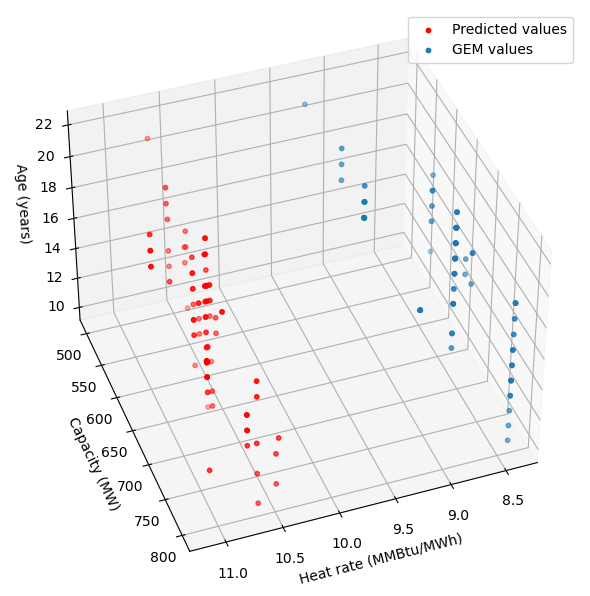

In [14]:

ax = plt.figure(figsize=(8, 6)).add_subplot(projection='3d')

# Plot a sin curve using the x and y axes.
x = predicted_gem_heat_value
y = gem_capacity
ax.scatter(x, y, zs=gem_age, zdir='z', color='red', s=10, label='Predicted values')

x1 = gem_heat_rate
y1 = gem_capacity
ax.scatter(x1, y1, zs=gem_age, zdir='z', color='tab:blue', s=10, label='GEM values')

# Make legend, set axes limits and labels
ax.legend()
ax.set_xlabel('Heat rate (MMBtu/MWh)')
ax.set_ylabel('Capacity (MW)')
ax.set_zlabel('Age (years)')

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=40., azim=70)
ax.dist = 10


plt.tight_layout()
plt.savefig('ML_training_plots/Gem_coal_3D_prediction_charateristics_super.png')